In [1]:
using DifferentialEquations, Plots, RecursiveArrayTools
using LinearAlgebra
using Convex, Mosek, MosekTools
using MatrixEquations

include("EllipsoidAlgebra.jl")
using .EllipsoidAlgebra

In [2]:
Plots.default(:fontfamily, "helvetica")

"helvetica"

In [3]:
const A = kron(I(1), [0 1; 0 0])
const B = kron(I(1), [0; 1])
const C = kron(I(1), [1 0.])

1×2 Matrix{Float64}:
 1.0  0.0

In [4]:
function dynamics(x, u)
    return A*x + B*u
end

dynamics (generic function with 1 method)

In [5]:
function plotReg(params)
    plot(x->-5, fillrange = x-> 5, params[:x_barr],5,  fillalpha = 0.35, label = "Unsafe Region", linewidth=0, fillcolor=:red)
end

plotReg (generic function with 1 method)

In [6]:
function defaultParams()

    params = Dict()
    params[:v_des] = 1.0
    params[:tspan] = (0, 20.0)
    params[:x_barr] = 3.0
    
    # cbf controller
    params[:α0] = 3.0
    params[:α1] = 2.0
    
    # lipschitz constants
    params[:γh] = sqrt(1.0 + params[:α0]^2)
    params[:γ_Lfh_αh] = sqrt((params[:α0]*params[:α1])^2 + (params[:α0] + params[:α1])^2)
    params[:γ_Lfh] = params[:α0]
    params[:γ_αh] = sqrt((params[:α0]*params[:α1])^2 + (params[:α1])^2)
    
    # observer design
    params[:θ] = 2.0
    params[:P] = lyap(A' + params[:θ]*I, -C'*C)
    params[:eigminP] = eigmin(params[:P])
    params[:L] = 0.5*params[:P] \ C'

    # simulation params
    params[:x0] = [0.5,1.]
    params[:x̂0] = [0,0.]
    params[:fs0] = ArrayPartition(params[:x0], params[:x̂0])
    
    params[:V0] = dot(params[:x0] - params[:x̂0], params[:P], params[:x0] - params[:x̂0])
    
    return params
end

params= defaultParams()

Dict{Any, Any} with 17 entries:
  :α1       => 2.0
  :γ_Lfh_αh => 7.81025
  :γ_Lfh    => 3.0
  :tspan    => (0, 20.0)
  :V0       => 0.03125
  :α0       => 3.0
  :x_barr   => 3.0
  :v_des    => 1.0
  :x0       => [0.5, 1.0]
  :fs0      => ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}}…
  :γ_αh     => 6.32456
  :θ        => 2.0
  :P        => [0.25 -0.0625; -0.0625 0.03125]
  :x̂0      => [0.0, 0.0]
  :γh       => 3.16228
  :L        => [16.0; 32.0]
  :eigminP  => 0.0146522

In [7]:
""" 
this function does convex opt based observer design
"""
function observerDesigner(θ)
    
    P = Semidefinite(2)
    Y = Variable(2,1)
    
    M = P*A + A'*P - Y*C - C'*Y' + 2*θ*P
    
    cons = [-M in :SDP, P-0.1*collect(I(2)) in :SDP]
    
    prob = minimize(eigmax(P), cons)
    
    Convex.solve!(prob, Mosek.Optimizer, silent_solver=true)
    
    @assert prob.status == Convex.MOI.OPTIMAL
    
    P_sol = Symmetric(evaluate(P)) |> collect
    
    L = P_sol \ C'
    
    
    return P_sol, L
end

observerDesigner

In [8]:
function controller_basic(state, params)
    return [1.0]
end

controller_basic (generic function with 1 method)

In [9]:
controller_basic(params[:x0], params)

1-element Vector{Float64}:
 1.0

In [10]:
function simulate_basic(state, params, time)
    u = controller_basic(state, params)
    xdot = dynamics(state, u)
    return xdot
end

sol_basic = solve(ODEProblem(simulate_basic, params[:x0], params[:tspan], params));


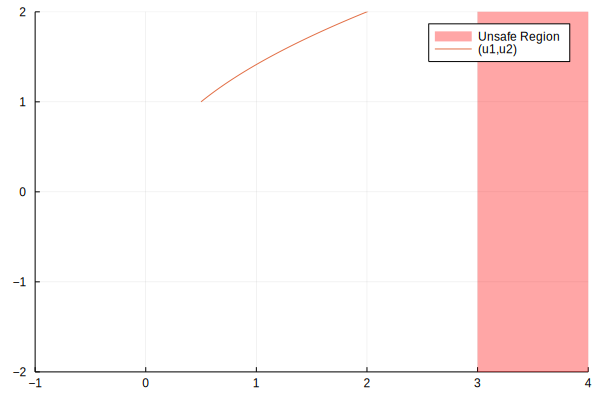

In [11]:
plotReg(params)
plot!(sol_basic, vars=(1,2))
xlims!(-1,4)
ylims!(-2,2)

## Basic CBF

In [12]:
function h_nom(state, params)
    return params[:x_barr] - state[1]
end
    
function h(state, params) 
    x, vx = state
    return -vx + params[:α0]*(-x + params[:x_barr])
end
function dhdx(state, params)
    return [-params[:α0], -1]'
end
function Lfh(state, params)
    x, vx = state
    return -params[:α0]*vx
end
function Lgh(state, params)
    return [-1]'
end

Lgh (generic function with 1 method)

In [13]:
function CBF_controller(state, u_des, params)
    u = Variable(1)
    cons = [Lfh(state, params) + Lgh(state, params) * u >= -params[:α1] * h(state, params)]
    prob = minimize(sumsquares(u-u_des), cons)
    Convex.solve!(prob, Mosek.Optimizer, silent_solver=true)
    @assert prob.status == Convex.MOI.OPTIMAL
    return [evaluate(u)]
end

CBF_controller (generic function with 1 method)

In [14]:
controller_basic(params[:x0], params)

1-element Vector{Float64}:
 1.0

In [15]:
CBF_controller(params[:x0], controller_basic(params[:x0], params), params)

1-element Vector{Float64}:
 0.9999981020824487

In [16]:
function simulate_cbf(state, params, time)
    u_des =  controller_basic(state, params)
    u = CBF_controller(state, u_des, params)
    xdot = dynamics(state, u)
    return xdot
end

simulate_cbf (generic function with 1 method)

In [17]:
sol_cbf = solve(ODEProblem(simulate_cbf, params[:x0], params[:tspan], params));

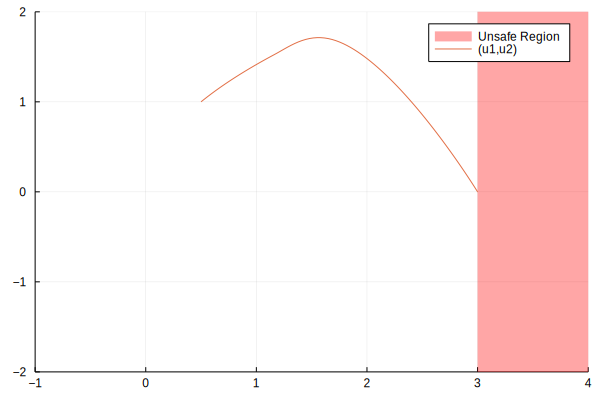

In [18]:
plotReg(params)
plot!(sol_cbf, vars=(1,2))
xlims!(-1,4)
ylims!(-2,2)

## Utility Functions

In [19]:
function get_control(observer_controller, sol, params)
    
    function _u(t)
        x = sol(t).x[1]
        x̂ = sol(t).x[2]

        y = C*x 
    
        u, x̂dot = observer_controller(t, x̂, y, params)
    
        return u
    end
    
    return _u
end

get_control (generic function with 1 method)

In [20]:
function closed_loop_generator(observer_controller)
    
    function _sim!(dfs, fs, params, time)
        x = fs.x[1]
        x̂ = fs.x[2]

        y = C*x 
    
        u, x̂dot = observer_controller(time, x̂, y, params)
    
        xdot = dynamics(x, u)
        x̂dot = observer(x̂, y, u, params)

        dfs.x[1] .= xdot
        dfs.x[2] .= x̂dot
        
    end
    
    return _sim!
end

closed_loop_generator (generic function with 1 method)

In [21]:
function plotSol(sol)
    p1 = plotReg(params)

    plot!(sol, vars=(1,2), label="True State", color=:blue)
    plot!(sol, vars=(3,4), label="Est State", color=:blue, linestyle=:dash)

    e0 = EllipsoidAlgebra.Ellipsoid(params[:x̂0], params[:P], params[:V0])
    EllipsoidAlgebra.plotEllipse!(e0, label="Est Bound", color=:gray, linestyle=:dash, linewidth=0.25)

    for t=0:0.05:params[:tspan][2]
        x̂ = sol(t).x[2]
        V = params[:V0] * exp(-2*params[:θ] * t)
        e = EllipsoidAlgebra.Ellipsoid(x̂, params[:P], V)
        EllipsoidAlgebra.plotEllipse!(e, label=false, color=:gray, linestyle=:dash, linewidth=0.25)
    end
    xlabel!("x")
    ylabel!("v_x")
    xlims!(-1,4)
    ylims!(-2,2)
    return plot!(aspect_ratio=1)
end

plotSol (generic function with 1 method)

## CBFs without Interconnection

In [22]:
function observer(x̂, y, u, params)
    x̂dot  = A * x̂ + B * u + params[:L]*(y -  C * x̂)
    return x̂dot
end

observer (generic function with 1 method)

In [23]:
function disconnected_observer_controller(t, x̂, y, params)
    
    u_des = controller_basic(x̂, params)
    u = CBF_controller(x̂, u_des, params)
    
    x̂dot  = observer(x̂, y, u, params)
    
    return u, x̂dot
end 

disconnected_observer_controller (generic function with 1 method)

In [24]:
closed_loop_disconnected = closed_loop_generator(disconnected_observer_controller)

(::var"#_sim!#6"{typeof(disconnected_observer_controller)}) (generic function with 1 method)

## Connected Observer-Controller V1

In [25]:
function controller_1(x̂, y, u_des, M, Mdot, params)
    
    γh = params[:γh]
    
    u = Convex.Variable(1)
    
    h_ = h(x̂, params)
    Lfh_ = Lfh(x̂, params)
    Lgh_ = Lgh(x̂, params)
    Llh_ = dhdx(x̂, params) * params[:L] * (y - C * x̂)
    
    cons = [Lfh_ + Lgh_*u + Llh_ >= -params[:α1] * (h_ - γh*M) + γh*Mdot]
    
    prob = minimize(sumsquares(u-u_des), cons)
    Convex.solve!(prob, Mosek.Optimizer, silent_solver=true)
    
    @assert prob.status == Convex.MOI.OPTIMAL
    
    return [evaluate(u)]
end
    

controller_1 (generic function with 1 method)

In [26]:
function connected_observer_controller_1(time, x̂, y, params)
    
    V = params[:V0] * exp(-2*params[:θ]*time)
    Vdot = -2*params[:θ]*V

    M = sqrt(V/params[:eigminP])
    Mdot = Vdot/(2 * sqrt(params[:eigminP]*V))
    
    u_des = controller_basic(x̂, params)
    
    u = controller_1(x̂, y, u_des, M, Mdot, params)
    
    x̂dot = observer(x̂, y, u, params)
    
    return u, x̂dot
end
    

connected_observer_controller_1 (generic function with 1 method)

In [27]:
closed_loop_connected_1 = closed_loop_generator(connected_observer_controller_1)

(::var"#_sim!#6"{typeof(connected_observer_controller_1)}) (generic function with 1 method)

## Connected Observer-Controller V2

In [28]:
function controller_2(x̂, y, u_des, M, params)

    γh = params[:γh]
    γ_Lfh_ah = params[:γ_Lfh_αh]

    α1 = params[:α1]
    h_ = h(x̂, params)
    Lfh_ = Lfh(x̂, params)
    Lgh_ = Lgh(x̂, params)
 
    u = Convex.Variable(1)
    
    cons = [Lfh_  + α1*h_ - γ_Lfh_ah*M + Lgh_*u >= 0.0]
    
    prob = minimize(sumsquares(u-u_des), cons)
    Convex.solve!(prob, Mosek.Optimizer, silent_solver=true)
    
    @assert prob.status == Convex.MOI.OPTIMAL
    
    return [evaluate(u)]
end

function connected_observer_controller_2(time, x̂, y, params)
    
    V = params[:V0] * exp(-2*params[:θ]*time)
    M = sqrt(V/params[:eigminP])
    
    u_des = controller_basic(x̂, params)
    
    u = controller_2(x̂, y, u_des, M, params)
    
    x̂dot = observer(x̂, y, u, params)
    
    return u, x̂dot
end


connected_observer_controller_2 (generic function with 1 method)

In [29]:
closed_loop_connected_2 = closed_loop_generator(connected_observer_controller_2)

(::var"#_sim!#6"{typeof(connected_observer_controller_2)}) (generic function with 1 method)

## Simulate All

In [76]:
function defaultParams()

    params = Dict()
    params[:v_des] = 1.0
    params[:tspan] = (0, 20.0)
    params[:x_barr] = 3.0
    
    # cbf controller
    params[:α0] = 3.0
    params[:α1] = 2.0
    
    # lipschitz constants
    params[:γh] = sqrt(1.0 + params[:α0]^2)
    params[:γ_Lfh_αh] = sqrt((params[:α0]*params[:α1])^2 + (params[:α0] + params[:α1])^2)
    params[:γ_Lfh] = params[:α0]
    params[:γ_αh] = sqrt((params[:α0]*params[:α1])^2 + (params[:α1])^2)
    
    # observer design
    params[:θ] = 0.5
    params[:P] = lyap(A' + params[:θ]*I, -C'*C)
    params[:eigminP] = eigmin(params[:P])
    params[:L] = 0.5*params[:P] \ C'
    
#     params[:P], params[:L] = observerDesigner(params[:θ])
#     params[:eigminP] = eigmin(params[:P])

    # simulation params
    params[:x0] = [-0.5,1.]
    params[:x̂0] = [0,0.]
    params[:fs0] = ArrayPartition(params[:x0], params[:x̂0])
    
    params[:V0] = dot(params[:x0] - params[:x̂0], params[:P], params[:x0] - params[:x̂0])
    
    return params
end

params= defaultParams()

Dict{Any, Any} with 17 entries:
  :α1       => 2.0
  :γ_Lfh_αh => 7.81025
  :γ_Lfh    => 3.0
  :tspan    => (0, 20.0)
  :V0       => 3.25
  :α0       => 3.0
  :x_barr   => 3.0
  :v_des    => 1.0
  :x0       => [-0.5, 1.0]
  :fs0      => ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}}…
  :γ_αh     => 6.32456
  :θ        => 0.5
  :P        => [1.0 -1.0; -1.0 2.0]
  :x̂0      => [0.0, 0.0]
  :γh       => 3.16228
  :L        => [4.0; 2.0]
  :eigminP  => 0.381966

In [77]:
sol_disconnected = solve(ODEProblem(closed_loop_disconnected, params[:fs0], params[:tspan], params));

In [78]:
sol_connected_1 = solve(ODEProblem(closed_loop_connected_1, params[:fs0], params[:tspan], params));

In [79]:
sol_connected_2 = solve(ODEProblem(closed_loop_connected_2, params[:fs0], params[:tspan], params));

# Plot All

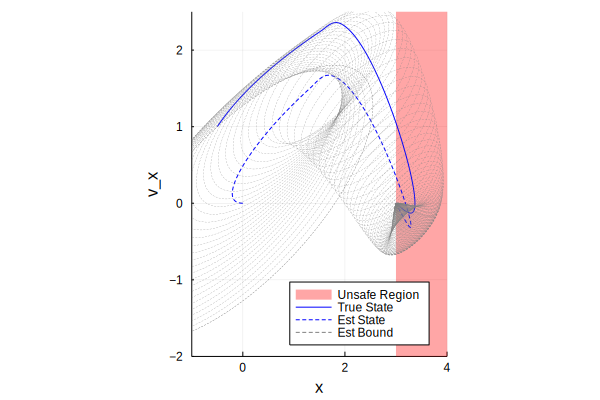

In [80]:
p1 = plotSol(sol_disconnected)
plot!(aspect_ratio=1.5)
plot!(xticks=[0,2,4])
ylims!(-2,2.5)
plot!(legend=:bottomright)
savefig("disconnected.pdf")
plot!()

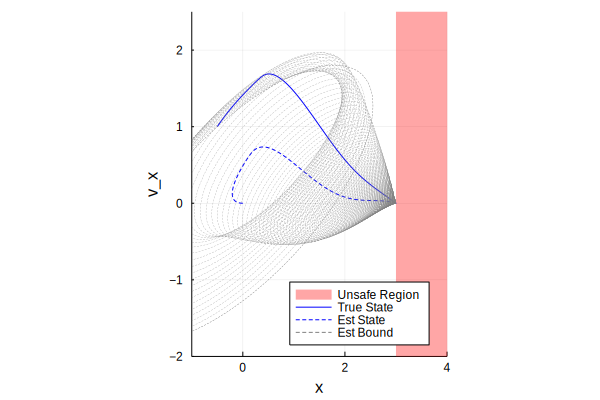

In [81]:
p2 = plotSol(sol_connected_1)
plot!(aspect_ratio=1.5)
plot!(xticks=[0,2,4])
ylims!(-2,2.5)
plot!(legend=:bottomright)
savefig("connected_1.pdf")
plot!()

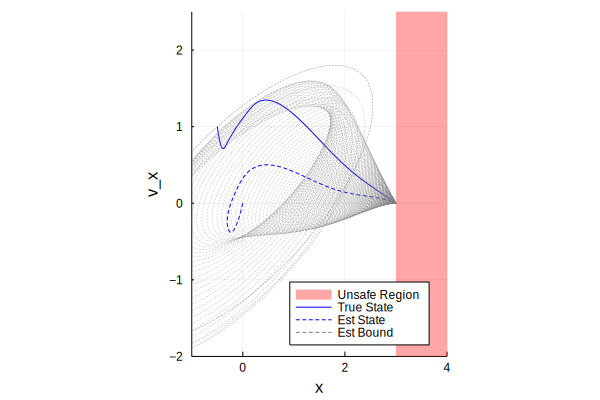

In [82]:
p3 = plotSol(sol_connected_2)
plot!(aspect_ratio=1.5)
plot!(xticks=[0,2,4])
plot!(legend=:bottomright)
ylims!(-2,2.5)
plot!()
savefig("connected_2.pdf")
plot!()


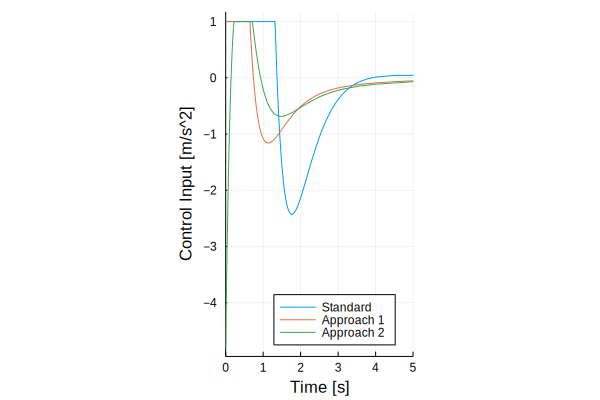

In [83]:
control_disconnected = get_control(disconnected_observer_controller, sol_disconnected, params);
control_1 = get_control(connected_observer_controller_1, sol_connected_1, params);
control_2 = get_control(connected_observer_controller_2, sol_connected_2, params);

plot(t->first(control_disconnected(t)), params[:tspan]..., label="Standard")
plot!(t->first(control_1(t)), params[:tspan]..., label="Approach 1")
plot!(t->first(control_2(t)), params[:tspan]..., label="Approach 2")

xlims!(0, 5.0)
plot!(aspect_ratio=1.5)
xlabel!("Time [s]")
ylabel!("Control Input [m/s^2]")
plot!(legend=:bottomright)
savefig("input.pdf")
plot!()

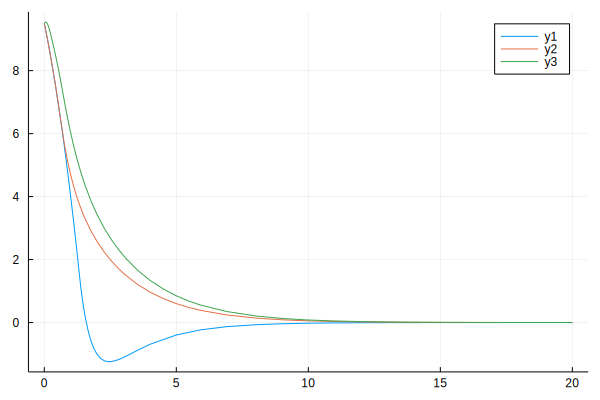

In [84]:
plot(t->h(sol_disconnected(t).x[1], params), params[:tspan]...)
plot!(t->h(sol_connected_1(t).x[1], params), params[:tspan]...)
plot!(t->h(sol_connected_2(t).x[1], params), params[:tspan]...)

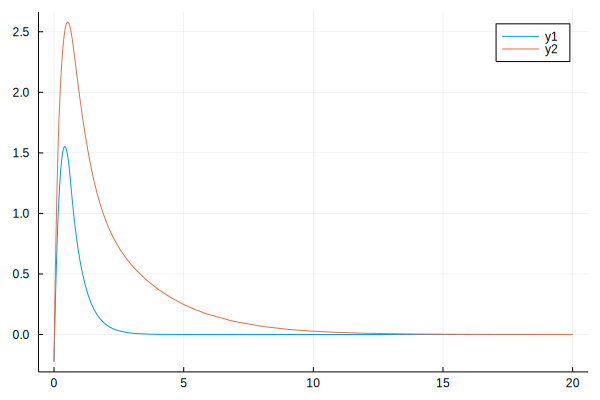

In [85]:
M(t) = sqrt(params[:V0] * exp(-2*params[:θ]*t)/eigmin(params[:P]))

plot(t->h(sol_connected_1(t).x[2], params) - params[:γh]*M(t), params[:tspan]...)

plot!(t->h(sol_connected_2(t).x[2], params) - params[:γh]*M(t), params[:tspan]...)